# Foreign Exchange Rate Prediction using Multiple Time Step LSTM Recurrent Neural Network

In [1]:
#Importing Linraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
import keras
import math
import yfinance as yf
import numpy as np
import pandas as pd
import pywt
from pywt import wavedec
from pywt import waverec
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error


In [2]:
def denoise_preprocess(fx_data):

#taking closing price data
    combined_data = fx_data['Time Serie'] + fx_data['CANADA - CANADIAN DOLLAR/US$'].astype(str)

    # Create a new DataFrame from the combined_data Series
    formatted_df = pd.DataFrame(combined_data)

    # Split the combined data into two separate columns 'Date' and 'Price'
    formatted_df[['Date', 'Price']] = formatted_df[0].str.extract(r'(\d{4}-\d{2}-\d{2})(.*)')

    # Convert 'Date' to datetime and 'Price' to a numeric type (float)
    formatted_df['Date'] = pd.to_datetime(formatted_df['Date'])
    formatted_df['Price'] = pd.to_numeric(formatted_df['Price'], errors='coerce')  # 'coerce' will set 'nan' strings to NaN

    # Set 'Date' as the index of the DataFrame
    formatted_df.set_index('Date', inplace=True)

    return formatted_df['Price']

def wavelet_denoise(fx_data,train):
        #initiate wavelet type and wavelet decomposition level variables
    level = 2 #wavelet transform decomposition level
    wavelet = 'db2' #wavelet type. here we choose wavelet Daubechies 2 (db2)
    #making function for calculating mean absolute deviation for thresholding

    def mad(d, axis=None):
        """ Mean absolute deviation of a signal """
        return np.mean(np.absolute(d - np.mean(d, axis)), axis)

    #decompositon/Discrete Wavelet Transform
    level = int(level)
    wavelet = wavelet
    coeff = wavedec(train, wavelet, level=level)
    level, wavelet, coeff
    #thresholding
    sigma = mad(coeff[-level])/0.6745
    threshold = sigma * np.sqrt(2*np.log(len(train)))
    coeff[1:] = (pywt.threshold(i, value=threshold, mode="soft") for i in coeff[1:])
    #reconstruction/Inverse Discrete Wavelet Transform
    denoised = waverec(coeff, wavelet)
    train = train.reset_index()
    if len(train)!=len(denoised):
        denoised = denoised[:-1]
    train ['denoised'] = denoised
    fx_data['denoised'] = denoised
    return train

def plot_before_after_denoise(original, denoised):
    #plotting the actual stock price data and the denoised data
    plt.figure(figsize=(15, 8))
    plt.title('Entire Denoised Dataset')
    plt.plot(original['Time Serie'], original['CANADA - CANADIAN DOLLAR/US$'])
    plt.plot(original['Time Serie'], denoised)
    plt.xlabel('Time Serie')
    plt.ylabel('CANADA - CANADIAN DOLLAR/US$')
    plt.legend(['Actual data', 'Denoised data'], loc='best')


In [3]:
#Reading dataset
data_set = pd.read_csv('sample_data/Foreign_Exchange_Rates.csv', na_values='ND')
data_set_plot = pd.read_csv('sample_data/Foreign_Exchange_Rates.csv', na_values='ND')

In [4]:
# Load dataset
data = pd.read_csv('sample_data/Foreign_Exchange_Rates.csv', na_values='ND')
data.interpolate(inplace=True)  # Handling missing values by interpolation
data.isnull().sum()
data_set.interpolate(inplace=True)
data_set.isnull().sum()
denoised = wavelet_denoise(data_set, denoise_preprocess(data_set))

df = data['CANADA - CANADIAN DOLLAR/US$'].values.reshape(-1, 1)
df_dn = np.array(denoised['denoised']).reshape(-1,1)
# plot_before_after_denoise(data_set, denoised['denoised'])


In [5]:
scaler = MinMaxScaler()
scaler_dn = MinMaxScaler()
df_scaled = scaler.fit_transform(df)
df_dn_scaled = scaler_dn.fit_transform(df_dn)
# Parameters
n_steps_in = 14   # Number of past days to use for predicting the future
n_steps_out = 7   # Number of future days to predict

# Split dataset
train = df_scaled[:4800]
test = df_scaled[4800:]
train_dn = df_dn_scaled[:4800]
test_dn = df_dn_scaled[4800:]

# Define the model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps_in, 1)))
model.add(Dense(n_steps_out))
model.compile(optimizer='adam', loss='mse')

model_dn = Sequential()
model_dn.add(LSTM(50, activation='relu', input_shape=(n_steps_in, 1)))
model_dn.add(Dense(n_steps_out))
model_dn.compile(optimizer='adam', loss='mse')

# Training model
def create_dataset(data, n_steps_in, n_steps_out):
    X, y = [], []
    if len(data) >= n_steps_in + n_steps_out:
        for i in range(len(data) - n_steps_in - n_steps_out + 1):
            X.append(data[i:(i + n_steps_in)])
            y.append(data[(i + n_steps_in):(i + n_steps_in + n_steps_out)])
        return np.array(X), np.array(y)
    else:
        print(f"Not enough data to create dataset. Needed: {n_steps_in + n_steps_out}, available: {len(data)}")
        return np.array([]), np.array([])  # Return empty arrays if not enough data


X_train, y_train = create_dataset(train, n_steps_in, n_steps_out)
print(X_train.shape)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
model.fit(X_train, y_train, epochs=5, batch_size=32)

X_train_dn, y_train_dn = create_dataset(train_dn, n_steps_in, n_steps_out)
X_train_dn = X_train_dn.reshape((X_train_dn.shape[0], X_train_dn.shape[1], 1))
model_dn.fit(X_train_dn, y_train_dn, epochs=5, batch_size=32)

# Predicting and calculating MSE for test data
test_predictions = []
test_actual = []

for i in range(0, len(test) - n_steps_in, n_steps_out):
    X_test, y_test = create_dataset(test[i:(i + n_steps_in + n_steps_out)], n_steps_in, n_steps_out)
    if len(X_test) == 0:
        break
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
    y_pred = model.predict(X_test)
    test_predictions.extend(y_pred.flatten())
    test_actual.extend(y_test.flatten())

test_predictions_dn = []
test_actual_dn = []

for i in range(0, len(test_dn) - n_steps_in, n_steps_out):
    X_test_dn, y_test_dn = create_dataset(test_dn[i:(i + n_steps_in + n_steps_out)], n_steps_in, n_steps_out)
    if len(X_test_dn) == 0:
        break
    X_test_dn = X_test_dn.reshape((X_test_dn.shape[0], X_test_dn.shape[1], 1))
    y_pred_dn = model_dn.predict(X_test_dn)
    test_predictions_dn.extend(y_pred_dn.flatten())
    test_actual_dn.extend(y_test_dn.flatten())

# Inverse transform predictions and actuals
test_predictions = scaler.inverse_transform(np.array(test_predictions).reshape(-1, 1))
test_actual = scaler.inverse_transform(np.array(test_actual).reshape(-1, 1))

test_predictions_dn = scaler_dn.inverse_transform(np.array(test_predictions_dn).reshape(-1, 1))
test_actual_dn = scaler_dn.inverse_transform(np.array(test_actual_dn).reshape(-1, 1))



(4780, 14, 1)
Epoch 1/5
150/150 [==============================] - 5s 12ms/step - loss: 0.0491
Epoch 2/5
150/150 [==============================] - 2s 12ms/step - loss: 7.8595e-04
Epoch 3/5
150/150 [==============================] - 2s 11ms/step - loss: 6.8463e-04
Epoch 4/5
150/150 [==============================] - 2s 11ms/step - loss: 6.6537e-04
Epoch 5/5
150/150 [==============================] - 2s 12ms/step - loss: 6.1498e-04
Epoch 1/5
150/150 [==============================] - 3s 11ms/step - loss: 0.0393
Epoch 2/5
150/150 [==============================] - 2s 12ms/step - loss: 9.1832e-04
Epoch 3/5
150/150 [==============================] - 2s 12ms/step - loss: 7.1292e-04
Epoch 4/5
150/150 [==============================] - 2s 11ms/step - loss: 6.6380e-04
Epoch 5/5
1/1 [==============================] - 0s 27ms/step
Not enough data to create dataset. Needed: 21, available: 18
1/1 [==============================] - 0s 19ms/step
Not enough data to create dataset. Needed: 21, availab

In [6]:
# Compute MSE
mse = mean_squared_error(test_actual, test_predictions)
print("Mean Squared Error on Test Set:", mse)
variance_y = np.var(test_actual)
relative_mse = mse / variance_y
print("Dataset Variance: ", variance_y)
print("Relative MSE on Test Set:", relative_mse)

mse_dn = mean_squared_error(test_actual, test_predictions_dn)
print("Mean Squared Error on Test Set (Denoised):", mse_dn)
variance_y = np.var(test_actual)
relative_mse_dn = mse_dn / variance_y
print("Relative MSE on Test Set (Denoised):", relative_mse_dn)

Mean Squared Error on Test Set: 0.00010981914101441182
Dataset Variance:  0.00022684941404262516
Relative MSE on Test Set: 0.48410590557565525
Mean Squared Error on Test Set (Denoised): 0.00014091659081378084
Relative MSE on Test Set (Denoised): 0.6211900145675603


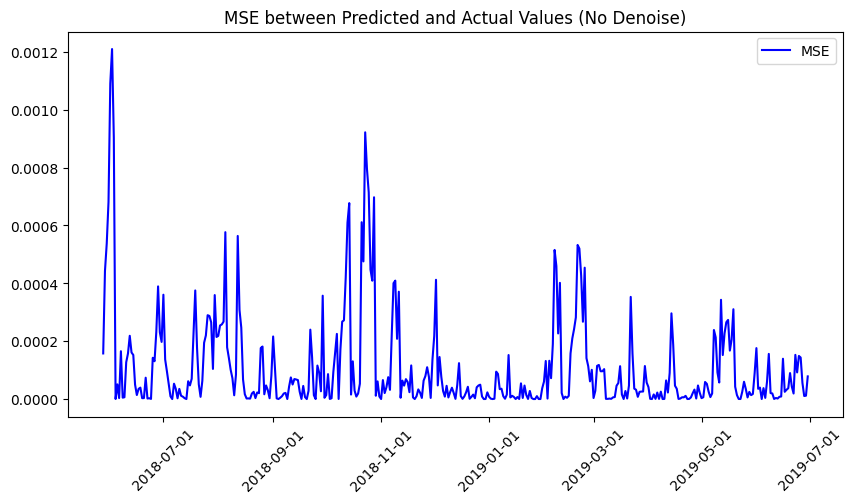

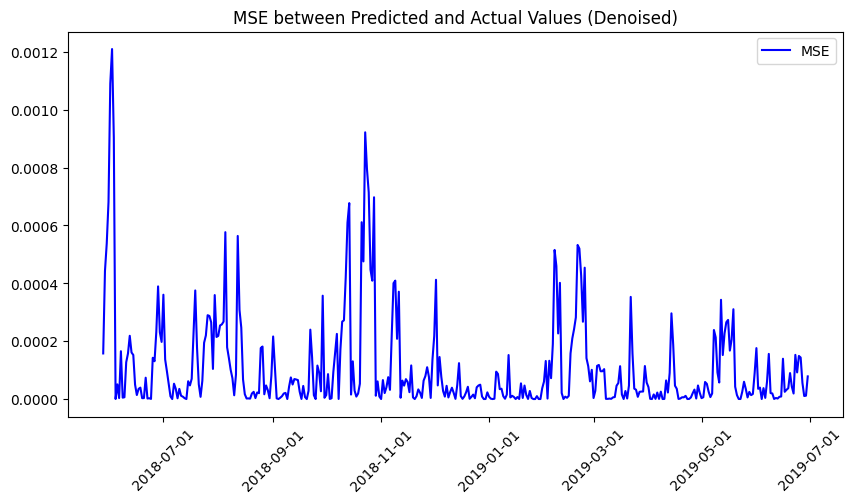

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Compute the squared errors
squared_errors = (test_predictions - test_actual) ** 2

date_range = pd.date_range(start=data_set_plot['Time Serie'][4800], periods=len(test_predictions), freq='D')

# Plotting
plt.figure(figsize=(10, 5))
plt.title('MSE between Predicted and Actual Values (No Denoise)')
plt.plot(date_range, squared_errors, label='MSE', color='b')

# Formatting the date on x-axis for better visibility
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m-%d'))

plt.legend()
plt.show()

squared_errors_dn = (test_predictions_dn - test_actual) ** 2

date_range = pd.date_range(start=data_set_plot['Time Serie'][4800], periods=len(test_actual), freq='D')

# Plotting
plt.figure(figsize=(10, 5))
plt.title('MSE between Predicted and Actual Values (Denoised)')
plt.plot(date_range, squared_errors, label='MSE', color='b')

# Formatting the date on x-axis for better visibility
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m-%d'))

plt.legend()
plt.show()


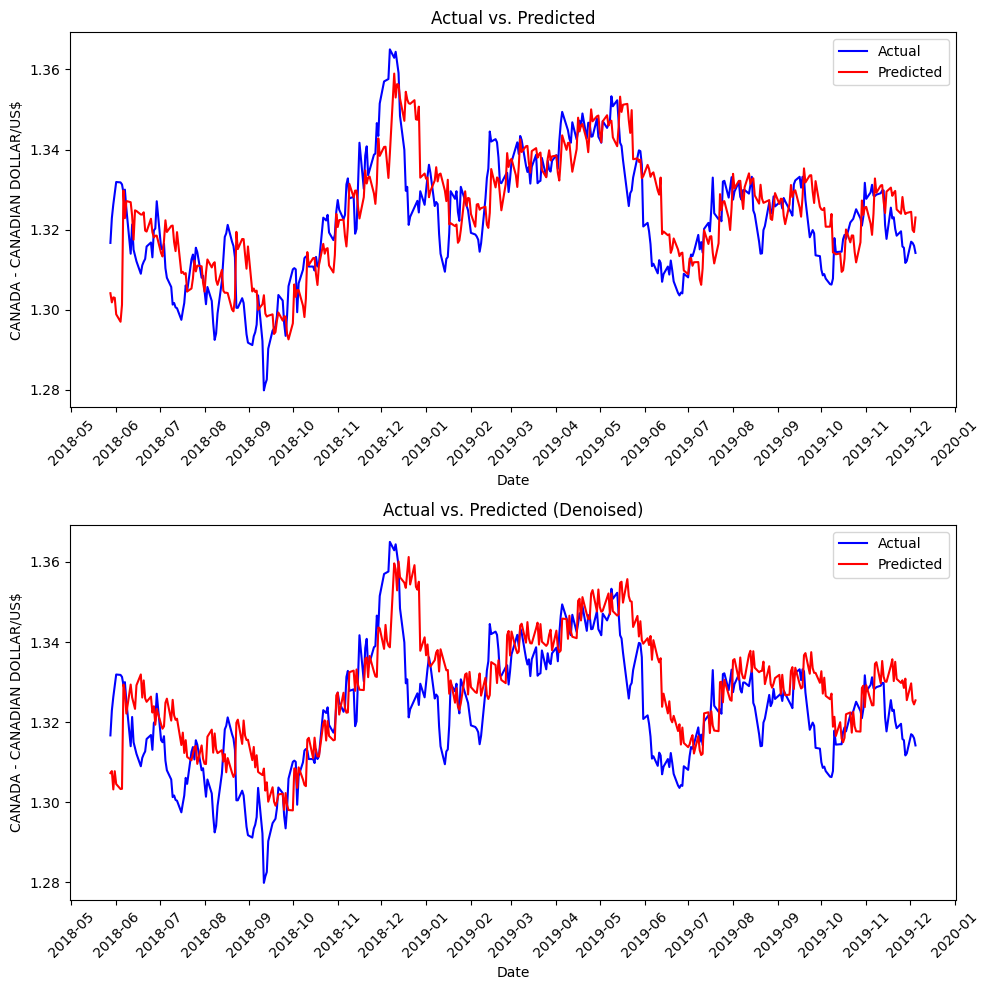

In [8]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

df = data[['Time Serie', 'CANADA - CANADIAN DOLLAR/US$']].copy()
df['Time Serie'] = pd.to_datetime(df['Time Serie'])
df_scaled = scaler.fit_transform(df['CANADA - CANADIAN DOLLAR/US$'].values.reshape(-1, 1))

test_dates = df['Time Serie'][4800:]
date_range = test_dates[:len(test_actual)].reset_index(drop=True)

# Create plots using subplots
fig, axs = plt.subplots(2, 1, figsize=(10, 10))

# First subplot for actual vs predicted
axs[0].plot(date_range, test_actual, label='Actual', color='blue')
axs[0].plot(date_range, test_predictions, label='Predicted', color='red')
axs[0].set_title('Actual vs. Predicted')
axs[0].set_xlabel('Date')
axs[0].set_ylabel('CANADA - CANADIAN DOLLAR/US$')
axs[0].xaxis.set_major_locator(mdates.MonthLocator())  # Set major ticks to month intervals
axs[0].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # Custom formatter to show year-month
axs[0].legend()

# Second subplot for actual vs predicted (Denoised)
axs[1].plot(date_range, test_actual, label='Actual', color='blue')
axs[1].plot(date_range, test_predictions_dn, label='Predicted', color='red')
axs[1].set_title('Actual vs. Predicted (Denoised)')
axs[1].set_xlabel('Date')
axs[1].set_ylabel('CANADA - CANADIAN DOLLAR/US$')
axs[1].xaxis.set_major_locator(mdates.MonthLocator())  # Use month locators for consistent formatting
axs[1].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
axs[1].legend()

plt.setp(axs[0].xaxis.get_majorticklabels(), rotation=45)
plt.setp(axs[1].xaxis.get_majorticklabels(), rotation=45)
plt.tight_layout()  # Adjust layout to make room for label rotation
plt.show()
